## Horizons and attributes

After [a question about attributes](http://earthscience.stackexchange.com/questions/5023/how-do-i-extract-seismic-amplitude-on-an-interpreted-horizon) on Earth Science Stack Exchange, I made a couple of illustrations for a blog post on the subject, *[An attribute analysis primer](http://agilegeoscience.com/blog/2015/6/26/an-attribute-analysis-primer)*. I want to show three things for now:

* Different types of surface or window to use for attribute extraction.
* The importance of interpolation type in extracting attributes at arbitrary time locations. 
* The range of different statistics one can extract over a window.

First, the usual imports.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We'd also like to make some fake data &mdash; fake horizons and a fake seismic trace. To do this, we need an interpolator.

In [3]:
from scipy.interpolate import spline

Now a horribly hacky function to generate a fake horizon. The components, `y0`, `y1`, etc., are strcture at different scales, which we then add together. The smart thing would be to do this in a loop for an arbitrary number of scales.

In [4]:
def generate():
    x = np.linspace(0, 100, 101)

    y0 = np.random.random(3) * 3
    x0 = np.linspace(0, 100, 3)
    y0 = spline(x0, y0, x)
    
    y1 = np.random.random(10)
    x1 = np.linspace(0, 100, 10)
    y1 = spline(x1, y1, x)

    y2 = np.random.random(40)/10 - 0.05
    x2 = np.linspace(0, 100, 40)
    y2 = spline(x2, y2, x)

    y3 = np.random.random(101)/10 - 0.05

    return x, y0 + y1 + y2 + y3

Now we can generate two fake horizons, and turn them into something 'depthlike' for more intuitive visualization. In retrospect, this was probably not necessary...

In [5]:
x, h1 = generate()
x, h2 = generate()

h1 = -(20*h1 + 100)
h2 = -(20*h2 + 200)

Now I make a 'zone' around `h1`, and a function to generate proportional slices. I also include an average horizon, but we don't use that one because it's essentially like the middle porportional horizon.

In [6]:
h1_top = h1 + 25
h1_bot = h1 - 50

h_avg = (h1 + h2) / 2

def prop(p, t):
    t = float(t)
    return h1 - (p/t)*(h1-h2)

Now tie it all together in a plot.

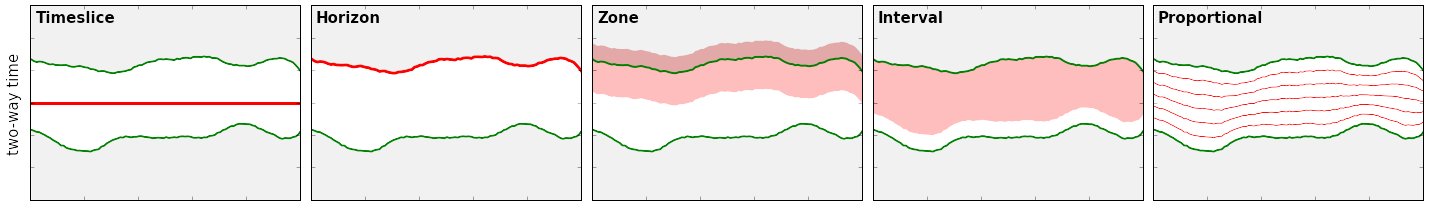

In [7]:
# Set up plot
fig = plt.figure(figsize=(20,3))

# Timeslice H1
ax0 = fig.add_subplot(151)
ax0.plot(h1, lw=2, color='g')
ax0.plot(h2, lw=2, color='g')
ax0.axhline(-200, color='r', lw=3)
ax0.fill_between(x, 0, h1, facecolor='gray', alpha=0.33, lw=0)
ax0.fill_between(x, h2, -400, facecolor='gray', alpha=0.33, lw=0)
ax0.set_ylim(-350,-50)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.set_ylabel('two-way time', size=15)
ax0.text(2, -75, 'Timeslice', size=15, weight="bold")

# Highlight H1
ax1 = fig.add_subplot(152)
ax1.plot(h1, lw=3, color='r')
ax1.plot(h2, lw=2, color='g')
ax1.fill_between(x, 0, h1, facecolor='gray', alpha=0.33, lw=0)
ax1.fill_between(x, h2, -400, facecolor='gray', alpha=0.33, lw=0)
ax1.set_ylim(-350,-50)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.text(2, -75, 'Horizon', size=15, weight="bold")

# Zone around H1
ax2 = fig.add_subplot(153)
ax2.plot(h1, lw=2, color='g')
ax2.plot(h1_top, lw=0)
ax2.plot(h1_bot, lw=0)
ax2.fill_between(x, h1_top, h1_bot, facecolor='r', alpha=0.5, lw=0)
ax2.plot(h2, lw=2, color='g')
ax2.fill_between(x, 0, h1, facecolor='gray', alpha=0.33, lw=0)
ax2.fill_between(x, h2, -400, facecolor='gray', alpha=0.33, lw=0)
ax2.set_ylim(-350,-50)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.text(2, -75, 'Zone', size=15, weight="bold")

# Between both (with shift maybe)
ax3 = fig.add_subplot(154)
ax3.plot(h1, lw=2, color='g')
ax3.plot(h2, lw=2, color='g')
ax3.fill_between(x, h1, h2+25, facecolor='r', alpha=0.5, lw=0)
ax3.fill_between(x, 0, h1, facecolor='gray', alpha=0.33, lw=0)
ax3.fill_between(x, h2, -400, facecolor='gray', alpha=0.33, lw=0)
ax3.set_ylim(-350,-50)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.text(2, -75, 'Interval', size=15, weight="bold")

# Proportional slicing
ax4 = fig.add_subplot(155)
ax4.plot(h1, lw=2, color='g')
ax4.plot(h2, lw=2, color='g')
slices = 5
for i in range(slices):
    ax4.plot(prop(i+1, slices+1), 'r')
ax4.fill_between(x, 0, h1, facecolor='gray', alpha=0.33, lw=0)
ax4.fill_between(x, h2, -400, facecolor='gray', alpha=0.33, lw=0)
ax4.set_ylim(-350,-50)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.text(2, -75, 'Proportional', size=15, weight="bold")

# Display
plt.tight_layout()
plt.savefig('/home/matt/horizons.png', dpi=150)
plt.show()

<hr />
## Different measures of amplitude at a given *t*

A horizon can cross a trace at any time *t* (within the precision of the horizon's TWT property). But a seismic trace only has samples at discrete times. So how do we determine the amplitude at arbitrary times on the trace? Interpolation!

In [8]:
amp_samples = np.array([0,1,3,0,-2,-5,-2,2,5,0,-1,1,0,2,4,1,-3,-5,-1,0])

In [9]:
# Interpolate for a smooth curve
from scipy.interpolate import spline, bisplev, lagrange
x = np.arange(len(amp_samples))
t = np.linspace(0, len(amp_samples)-1, 20000)
amp = spline(x, amp_samples, t)

In [10]:
horizon = 7.543

In [11]:
amp_spline = spline(x, amp_samples, t)
hor_spline = amp_spline[20000*horizon/19]
print(hor_spline)

4.41593421788


In [12]:
amp_linear = np.interp(t, x, amp_samples)
hor_linear = amp_linear[20000*horizon/19]
print(hor_linear)

3.63013150658


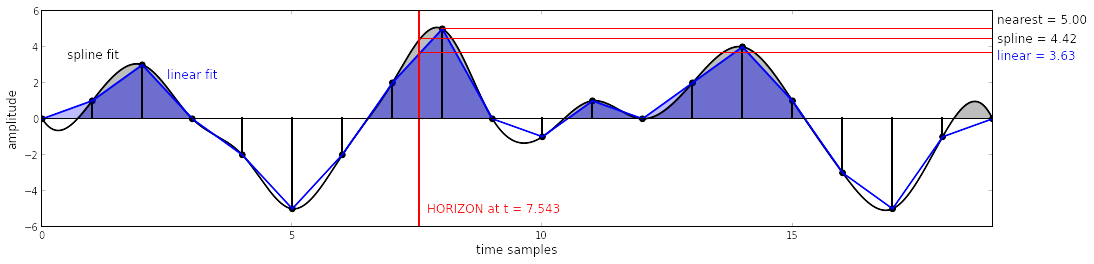

In [14]:
styles = {'ha':'left', 'va':'center', 'size':12}
fig = plt.figure(figsize=(16,4))

ax = fig.add_axes([0.05,0.15,0.825,0.75])

# Samples
ax.scatter(x, amp_samples, s=50, c='k', lw=0)
for i, v in enumerate(amp_samples):
    if v > 0:
        ax.axvline(x=i, ymin=0.5, ymax=0.5 + v/12., c='k', lw=2)
    else:
        ax.axvline(x=i, ymin=0.5 + v/12., ymax=0.5, c='k', lw=2)

# Spline interpolated
ax.plot(t, amp_spline, 'k', lw=2)
ax.fill_between(t, 0, amp_spline, where=amp>0, color='k', alpha=0.5, lw=0)
ax.text(0.5, 3.5, "spline fit", color='k', **styles)

# Linear interpolated
ax.plot(t, amp_linear, 'b', lw=2)
ax.fill_between(t, 0, amp_linear, where=amp_linear>0, color='b', alpha=0.5, lw=0)
ax.text(2.5, 2.5, "linear fit", color='b', **styles)

# Horizon crossing point and amplitudes
pos = 19.1
ax.axvline(x=horizon, c='r', lw=2)
ax.text(horizon+0.15, -5, "HORIZON at t = {}".format(horizon), color='r', **styles)

ax.axhline(y=5, xmin=8/19., c='r', lw=1)
ax.axhline(y=hor_spline, xmin=horizon/19., c='r', lw=1)
ax.axhline(y=hor_linear, xmin=horizon/19., c='r', lw=1)
ax.text(pos, 5+0.5, "nearest = {:.2f}".format(5), color='k', **styles)
ax.text(pos, hor_spline, "spline = {:.2f}".format(hor_spline), color='k', **styles)
ax.text(pos, hor_linear-0.1, "linear = {:.2f}".format(hor_linear), color='b', **styles)

# Axes etc.
ax.axhline(0, color='k')
ax.set_xlim(0, 19)
plt.xlabel('time samples', size=12)
plt.ylabel('amplitude', size=12)

plt.savefig('/home/matt/trace_sampling.png', dpi=150)
plt.show()

7.543 happens to be the position of the maximum 'energy' or magnitude of the complex trace...

In [15]:
import scipy.signal
h = scipy.signal.hilbert(amp)
print("Max magnitude:   {0:.2f}".format(np.amax(np.abs(h))))
print("Position of max: {0:.3f}".format(19. * (np.argmax(np.abs(h))/20000.)))

Max magnitude:   5.25
Position of max: 7.544


<hr />
## Different statistics from a zone

In [16]:
amp = amp_spline

In [17]:
def rms(a):
    mean_squares = np.sum(a**2.)/a.size
    return np.sqrt(mean_squares)

In [18]:
mean_amp = np.mean(amp); mean_amp

0.0064922903754030814

In [19]:
rms_amp = rms(amp); rms_amp

2.5986847965736879

In [20]:
avg_abs_amp = np.mean(abs(amp)); avg_abs_amp

2.0724055117964899

In [21]:
max_amp = np.amax(amp); max_amp

5.0791795368383132

We should also compute the Hilbert transform for a phase-independent amplitude 'envelope'. This is sometimes called 'relfection strength' or 'energy'.

In [22]:
import scipy.signal
h = scipy.signal.hilbert(amp)
avg_h = np.mean(np.abs(h))
max_h = np.amax(np.abs(h)); max_h

5.2524545342402051

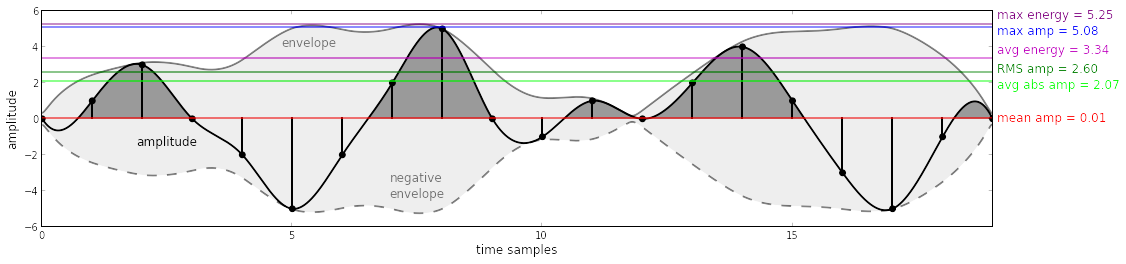

In [23]:
fig = plt.figure(figsize=(16,4))

ax = fig.add_axes([0.05,0.15,0.825,0.75])
ax.scatter(x, amp_samples, s=50, c='k', lw=0)
ax.fill_between(t, 0, amp, where=amp>0, color='k', alpha=0.5, lw=0)
for i, v in enumerate(amp_samples):
    if v > 0:
        ax.axvline(x=i, ymin=0.5, ymax=0.5 + v/12., c='k', lw=2)
    else:
        ax.axvline(x=i, ymin=0.5 + v/12., ymax=0.5, c='k', lw=2)
ax.plot(t, amp, 'k', lw=2)
abs_h = np.abs(h)
ax.plot(t, abs_h, 'k', lw=2, alpha=0.67)
line, = ax.plot(t, -abs_h, 'k--', lw=2, alpha=0.67)
line.set_dashes([10,10])
ax.fill_between(t, -abs_h, abs_h, color='k', alpha=0.25, lw=0)
        
# Add the mean and the RMS
linestyle = {'lw':2, 'alpha':0.67}
ax.axhline(mean_amp, color='r', **linestyle)
ax.axhline(rms_amp, color='g', **linestyle)
ax.axhline(avg_abs_amp, color='lime', **linestyle)
ax.axhline(max_amp, color='b', **linestyle)
ax.axhline(avg_h, color='m', **linestyle)
ax.axhline(max_h, color='purple', **linestyle)

# Add some labels
pos = 19.1
styles = {'ha':'left', 'va':'center', 'size':12}
ax.text(1.9, -1.3, "amplitude", color='k', **styles)
ax.text(4.8, 4.2, "envelope", color='k', alpha=0.67, **styles)
ax.text(7.5, -4.4, "negative\nenvelope", color='k', alpha=0.67, ha='center', size=12)
ax.text(pos, mean_amp, "mean amp = {:.2f}".format(mean_amp), color='r', **styles)
ax.text(pos, rms_amp+0.1, "RMS amp = {:.2f}".format(rms_amp), color='g', **styles)
ax.text(pos, avg_abs_amp-0.25, "avg abs amp = {:.2f}".format(avg_abs_amp), color='lime', **styles)
ax.text(pos, max_amp-0.25, "max amp = {:.2f}".format(max_amp), color='b', **styles)
ax.text(pos, avg_h+0.45, "avg energy = {:.2f}".format(avg_h), color='m', **styles)
ax.text(pos, max_h+0.45, "max energy = {:.2f}".format(max_h), color='purple', **styles)
ax.set_xlim(0, 19)
plt.xlabel('time samples', size=12)
plt.ylabel('amplitude', size=12)

plt.savefig('/home/matt/trace_stats.png', dpi=150)
plt.show()

<hr />
<img src="https://avatars1.githubusercontent.com/u/1692321?v=3&s=200" style="float:right;" width="50px" /><p style="color:gray; float:right;">© 2015 <a href="http://www.agilegeoscience.com/">Agile Geoscience</a> — <a href="https://creativecommons.org/licenses/by/4.0/">CC-BY</a> — Have fun!&nbsp;&nbsp;&nbsp;</p>